In [1]:
import pandas as pd
import numpy as np
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
%cd C:\\Users\\naray\\Desktop\\Case Studies\\6. Analyzing online Job Postings

C:\Users\naray\Desktop\Case Studies\6. Analyzing online Job Postings


In [3]:
df = pd.read_csv("data job posts.csv")
df=df[df['Title'].isnull()==False]
df.reset_index(inplace=True)

df.head(5)

,index,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


# `Job Nature :`

In [4]:
X=df['Title']

In [5]:
len(X)

18973

#### `Creating the corpus`

In [6]:
import re
corpus = []
for i in range(0, len(X)):
    review = re.sub(r'\W', ' ', str(X[i]))
#    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', '', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review)  

#### `Removing punctuations`

In [7]:
# Remove punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(corpus))

data_words[0]

['chief', 'financial', 'officer']

#### `Stopwords, bigram model, lemmatization`

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','na','Senior','new','branch','Junior','unit','department','Specialist','the','unit'])

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['chief', 'financial', 'officer']]


In [12]:
data_lemmatized[0:10]

[['chief', 'financial', 'officer'],
 ['community', 'connection', 'intern', 'pay', 'internship'],
 ['country', 'coordinator'],
 ['specialist'],
 ['software', 'developer'],
 [],
 ['chief', 'accountant', 'finance', 'assistant'],
 ['pay', 'part', 'full_time', 'programmatic', 'intern'],
 ['assistant', 'manage', 'director'],
 ['program', 'assistant']]

In [13]:
list2 = [x for x in data_lemmatized if x != []] # removeing null from list

In [14]:
for i in range(len(list2)):
    list2[i] = ' '.join(list2[i])

In [15]:
list2[0:5]

['chief financial officer',
 'community connection intern pay internship',
 'country coordinator',
 'specialist',
 'software developer']

In [16]:
# flat_list = []
# for sublist in list2:
#     for item in sublist:
#         flat_list.append(item)

#### `Selecting top 1000 titles for wordcloud`

In [50]:
data

'lawyer'

In [51]:
titlecount = {}
for data in list2:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1

In [52]:
len(titlecount)

1832

In [19]:
import heapq

# Selecting best 100 features
freq_words = heapq.nlargest(1000,titlecount,key=titlecount.get)

In [20]:
%%capture
#gather features
text = " ".join(freq_words)

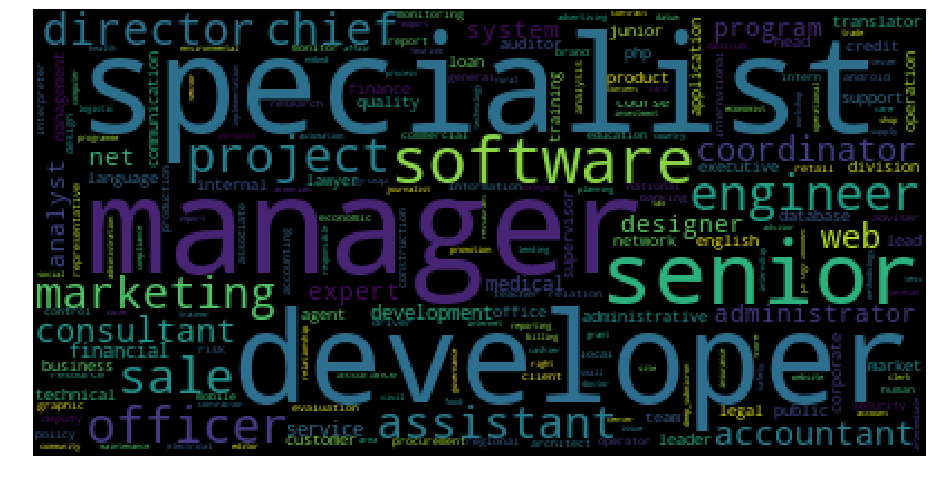

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### `Job nature changing overtime`

In [23]:
len(data_lemmatized)

18973

In [24]:
for i in range(len(data_lemmatized)):
    data_lemmatized[i] = ' '.join(data_lemmatized[i])

In [26]:
date_field=df['Year'].tolist()

len(date_field)

18973

In [27]:
df1 = pd.DataFrame(np.column_stack([data_lemmatized,date_field]), 
                               columns=['Job_title','Year'])

In [33]:
df1.head(5)

,Job_title,Year
0,chief financial officer,2004
1,community connection intern pay internship,2004
2,country coordinator,2004
3,specialist,2004
4,software developer,2004


In [30]:
df1.dtypes

Job_title    object
Year         object
dtype: object

In [31]:
#Converting year to numeric 

df1['Year']=df1['Year'].astype('int')

In [32]:
df1.dtypes

Job_title    object
Year          int32
dtype: object

In [41]:
df1.Year.value_counts()

2012    2140
2015    2009
2013    2009
2014    1980
2008    1782
2011    1695
2007    1538
2010    1506
2009    1191
2005    1138
2006    1111
2004     874
Name: Year, dtype: int64

In [42]:
# Divinding year into 3 equidistant bins to show change in job nature over 4 years period

df1['Year_bins']=pd.cut(df1['Year'],3,labels=['Period1','Period2','Period3'])

In [43]:
df1.pivot_table(values='Year',index='Year_bins',aggfunc=['min','max','count'])

,min,max,count
,Year,Year,Year
Year_bins,,,
Period1,2004,2007,4661
Period2,2008,2011,6174
Period3,2012,2015,8138


#### `Job nature from year 2004 to 2007`

In [72]:
X1=df1[df1['Year_bins']=='Period1'].iloc[:,0]

In [73]:
# Selecting top 500 jobs for the wordcloud

titlecount = {}
for data in X1:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1
            
# import heapq
freq_words = heapq.nlargest(500,titlecount,key=titlecount.get)

In [74]:
%%capture
#gather features
text = " ".join(freq_words)

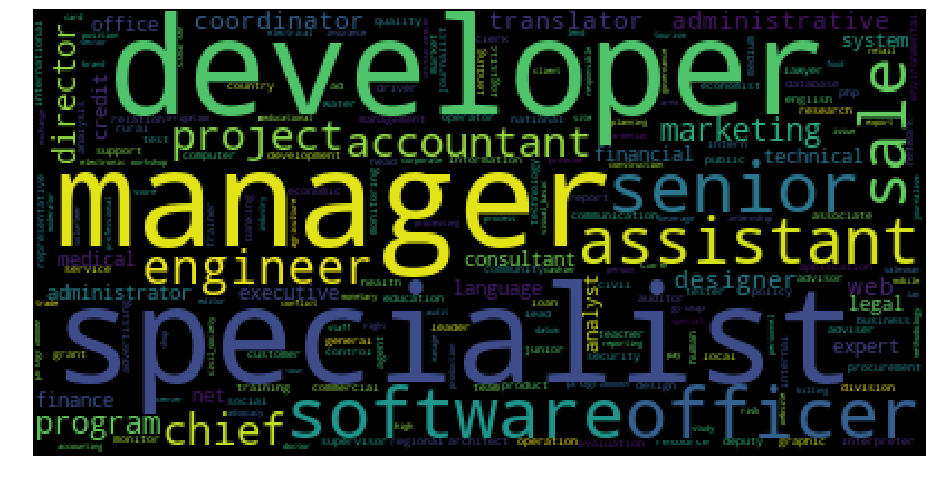

In [75]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### `Job nature from year 2008 to 2011`

In [76]:
X2=df1[df1['Year_bins']=='Period2'].iloc[:,0]

In [77]:
# Selecting top 500 jobs for the wordcloud

titlecount = {}
for data in X2:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1
            
# import heapq
freq_words = heapq.nlargest(500,titlecount,key=titlecount.get)

In [78]:
%%capture
#gather features
text = " ".join(freq_words)

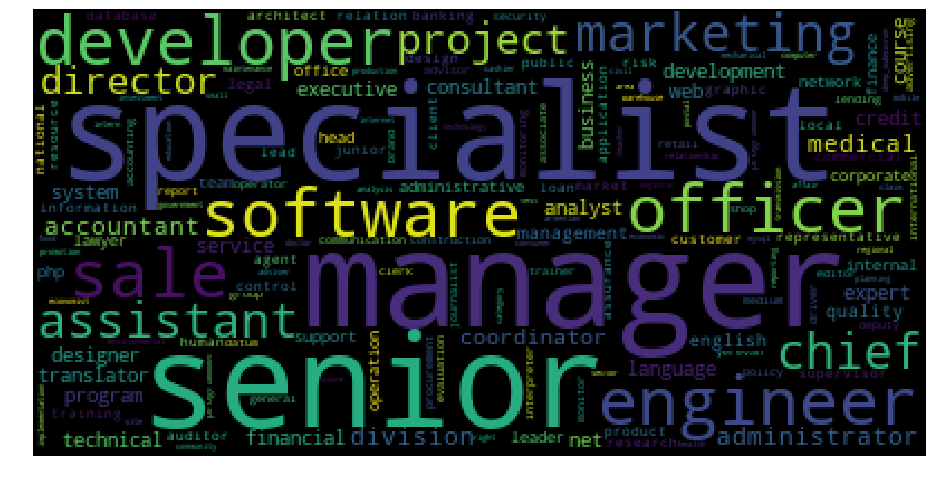

In [79]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### `Job nature from year 2012 to 2015`

In [80]:
X3=df1[df1['Year_bins']=='Period3'].iloc[:,0]

In [82]:
# Selecting top 500 jobs for the wordcloud

titlecount = {}
for data in X3:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1
            
# import heapq
freq_words = heapq.nlargest(500,titlecount,key=titlecount.get)

In [83]:
%%capture
#gather features
text = " ".join(freq_words)

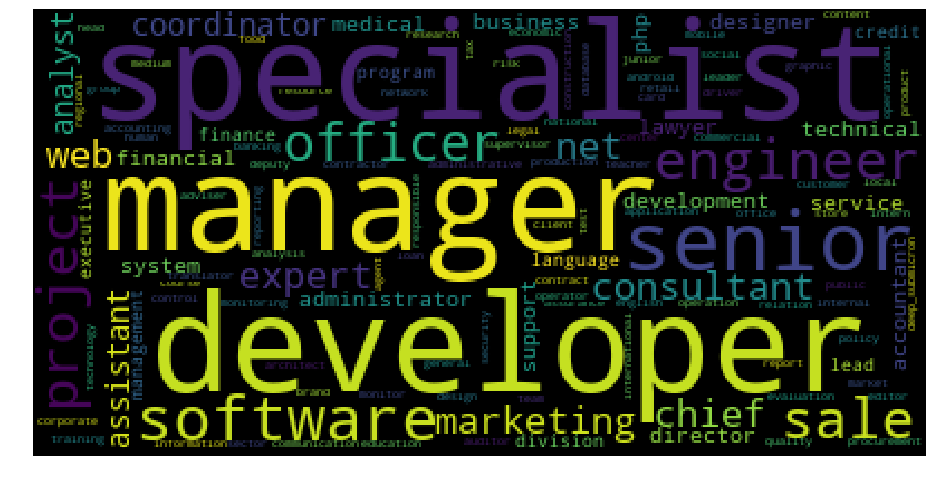

In [84]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# `IT Job Classification:`

In [390]:
# Defining X
#df['X1'] = df['Title'].str.cat(df['JobDescription'], sep =" ").str.cat(df['JobRequirment'], sep =" ").str.cat(df['RequiredQual'], sep =" ") 
df['X1'] = df['Title'].str.cat(df['JobRequirment'], sep =" ").str.cat(df['RequiredQual'], sep =" ")
X=df['X1']

# Defining Y
di={False:0,True:1}
df['IT_y']=df['IT'].map(di)
y=df['IT_y']

In [391]:
# Creating the corpus
import re
corpus = []
for i in range(0, len(X)):
    review = re.sub(r'\W', ' ', str(X[i]))
    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', '', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review)  

In [392]:
corpus[0]

'chief financial officer supervises financial management and administrative staff including assigning responsibilities reviewing employees work processes and products counseling employees giving performance evaluations and recommending disciplinary action serves as member of management team participating in both strategic and operational planning for the company directs and oversees the company financial management activities including establishing and monitoring internal controls managing cash and investments and managing the investment portfolio in collaboration with the investment team leader this includes but is not limited to evaluation of investment risk concentration risk fund deployment levels adequacy of loss and liquidity reserves assists investment team in development of proper documentation and internal systems directs and oversees the annual budgeting process including developing projections for financial planning and preparing budgets prepares external and internal financ

In [393]:
from nltk.stem import PorterStemmer
#sentences = nltk.sent_tokenize(paragraph)
stemmer = PorterStemmer()

# Stemming
for i in range(len(corpus)):
    words = nltk.word_tokenize(corpus[i])
    words = [stemmer.stem(word) for word in words]
    corpus[i] = ' '.join(words)  

In [433]:
corpus[0]

'chief financi offic supervis financi manag and administr staff includ assign respons review employe work process and product counsel employe give perform evalu and recommend disciplinari action serv as member of manag team particip in both strateg and oper plan for the compani direct and overse the compani financi manag activ includ establish and monitor intern control manag cash and invest and manag the invest portfolio in collabor with the invest team leader thi includ but is not limit to evalu of invest risk concentr risk fund deploy level adequaci of loss and liquid reserv assist invest team in develop of proper document and intern system direct and overse the annual budget process includ develop project for financi plan and prepar budget prepar extern and intern financi manag report such as audit financi statement tax return and report for the board of director and compani staff develop implement and maintain effici and effect account system and control to ensur complianc with na

In [ ]:
# Creating the Tf-Idf model directly
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 0.05 max_df = 0.8, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(corpus).toarray()

In [418]:
X.shape

(18973, 143)

# `Building Logistic Regression Model`

In [200]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(X,
                                              y,
                                              test_size=.3,
                                              random_state=42)

In [201]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit( train_x, train_y )

C:\Users\naray\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### `Evaluating the model`

In [202]:
#Predicting the test cases
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,logreg.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,logreg.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.9002108222066058
train_accuracy:  0.9111512687297644


In [203]:
print('AUC train :',metrics.roc_auc_score(train_y,logreg.predict(train_x)))
print('AUC test :',metrics.roc_auc_score(test_y,logreg.predict(test_x)))

AUC train : 0.8133088174308498
AUC test : 0.7993180721418982


Text(0.5, 15.0, 'Predicted label')

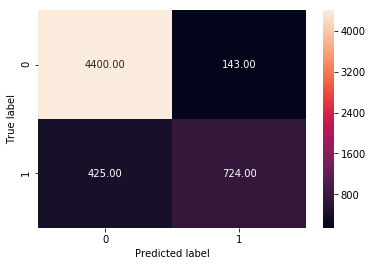

In [204]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix(test_y,
                            logreg.predict(test_x), [0,1] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [205]:
from sklearn.metrics import classification_report
print(classification_report(test_y,logreg.predict(test_x)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4543
           1       0.84      0.63      0.72      1149

    accuracy                           0.90      5692
   macro avg       0.87      0.80      0.83      5692
weighted avg       0.90      0.90      0.89      5692



In [206]:
test_predicted_prob=pd.DataFrame(logreg.predict_proba(test_x))[[1]]
test_predicted_prob.columns=['prob']
actual=test_y.reset_index()
actual.drop('index',axis=1,inplace=True)

# making a DataFrame with actual and prob columns
df_test_predict = pd.concat([actual, test_predicted_prob], axis=1)
df_test_predict.columns = ['actual','prob']
df_test_predict.head()

,actual,prob
0,0,0.025069
1,0,0.033306
2,1,0.986972
3,0,0.005376
4,0,0.055412


In [207]:
test_roc_like_df = pd.DataFrame()
test_temp = df_test_predict.copy()

for cut_off in np.linspace(0,1,50):
    test_temp['predicted'] = test_temp['prob'].apply(lambda x: 0 if x < cut_off else 1)
    test_temp['tp'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==1 else 0, axis=1)
    test_temp['fp'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==1 else 0, axis=1)
    test_temp['tn'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==0 else 0, axis=1)
    test_temp['fn'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==0 else 0, axis=1)
    sensitivity = test_temp['tp'].sum() / (test_temp['tp'].sum() + test_temp['fn'].sum())
    specificity = test_temp['tn'].sum() / (test_temp['tn'].sum() + test_temp['fp'].sum())
    
    accuracy=(test_temp['tp'].sum()+test_temp['tn'].sum()) / (test_temp['tp'].sum() + test_temp['fn'].sum()+test_temp['tn'].sum() + test_temp['fp'].sum())
    
    test_roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity,accuracy]).T
    test_roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity','accuracy']
    test_roc_like_df = pd.concat([test_roc_like_df, test_roc_like_table], axis=0)

In [208]:
test_roc_like_df.head()

,cutoff,sensitivity,specificity,accuracy
0,0.000000,1.000000,0.000000,0.201862
0,0.020408,0.987815,0.453665,0.561490
0,0.040816,0.977372,0.626899,0.697646
0,0.061224,0.973020,0.691834,0.748595
0,0.081633,0.967798,0.726832,0.775474


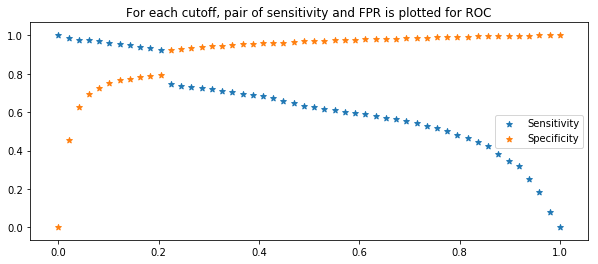

In [209]:
test_temp.sum()
plt.subplots(figsize=(10,4))
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['specificity'], marker='*', label='Specificity')
#plt.scatter(test_roc_like_df['cutoff'], 1-test_roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [210]:
## Finding ideal cut-off for checking if this remains same in OOS validation
test_roc_like_df['total'] = test_roc_like_df['sensitivity'] + test_roc_like_df['accuracy']
test_roc_like_df[test_roc_like_df['total']==test_roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.122449,0.953873,0.767114,0.804814,1.758687


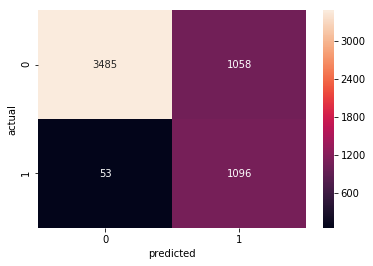

In [212]:
df_test_predict['predicted'] = df_test_predict['prob'].apply(lambda x: 1 if x > 0.122449 else 0)

import seaborn as sns
sns.heatmap(pd.crosstab(df_test_predict['actual'], df_test_predict['predicted']), annot=True, fmt='.0f')

In [213]:
accuracy=metrics.accuracy_score(df_test_predict.actual, df_test_predict.predicted)
print('Accuracy: ',round(accuracy,2))

Accuracy:  0.8


In [214]:
from sklearn.metrics import classification_report
print(classification_report(df_test_predict.actual, df_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      4543
           1       0.51      0.95      0.66      1149

    accuracy                           0.80      5692
   macro avg       0.75      0.86      0.76      5692
weighted avg       0.89      0.80      0.82      5692



# `Building Naive Bayes Model`

In [215]:
from sklearn.naive_bayes import GaussianNB

nb_clf=GaussianNB()

nb_clf.fit(train_x,train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

### `Evaluating the model`

In [216]:
#Predicting the test cases
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,nb_clf.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,nb_clf.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.809205903021785
train_accuracy:  0.8021986296212634


In [217]:
print('AUC train :',metrics.roc_auc_score(train_y,nb_clf.predict(train_x)))
print('AUC test :',metrics.roc_auc_score(test_y,nb_clf.predict(test_x)))

AUC train : 0.8369680636207059
AUC test : 0.8447142832238199


In [218]:
from sklearn.metrics import classification_report
print(classification_report(test_y,nb_clf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4543
           1       0.52      0.90      0.66      1149

    accuracy                           0.81      5692
   macro avg       0.74      0.84      0.76      5692
weighted avg       0.88      0.81      0.83      5692



Text(0.5, 15.0, 'Predicted label')

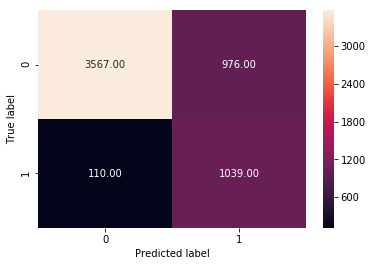

In [219]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix(test_y,
                            nb_clf.predict(test_x), [0,1] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

# `Random Forest Model`

In [222]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid={'n_estimators':[100, 200, 400, 600, 800]}

tree=GridSearchCV(RandomForestClassifier(oob_score=False,warm_start=True),param_grid,cv=5,n_jobs=-1)
tree.fit(train_x,train_y)

In [ ]:
tree.best_params_

In [223]:
radm_clf=RandomForestClassifier(oob_score=True,n_estimators=600,n_jobs=-1)
radm_clf.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

### `Evaluating the model`

In [224]:
#Predicting the test cases
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,radm_clf.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,radm_clf.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.9219957835558679
train_accuracy:  0.9704841502898878


In [225]:
print('AUC train :',metrics.roc_auc_score(train_y,radm_clf.predict(train_x)))
print('AUC test :',metrics.roc_auc_score(test_y,radm_clf.predict(test_x)))

AUC train : 0.924904214559387
AUC test : 0.8298707237504424


In [226]:
from sklearn.metrics import classification_report
print(classification_report(test_y,radm_clf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4543
           1       0.92      0.68      0.78      1149

    accuracy                           0.92      5692
   macro avg       0.92      0.83      0.87      5692
weighted avg       0.92      0.92      0.92      5692



Text(0.5, 15.0, 'Predicted label')

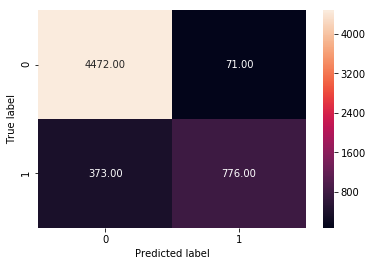

In [227]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix(test_y,
                            radm_clf.predict(test_x), [0,1] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [228]:
test_predicted_prob=pd.DataFrame(radm_clf.predict_proba(test_x))[[1]]
test_predicted_prob.columns=['prob']
actual=test_y.reset_index()
actual.drop('index',axis=1,inplace=True)

# making a DataFrame with actual and prob columns
df_test_predict = pd.concat([actual, test_predicted_prob], axis=1)
df_test_predict.columns = ['actual','prob']
df_test_predict.head()

,actual,prob
0,0,0.016667
1,0,0.035000
2,1,1.000000
3,0,0.006667
4,0,0.036667


In [229]:
test_roc_like_df = pd.DataFrame()
test_temp = df_test_predict.copy()

for cut_off in np.linspace(0,1,50):
    test_temp['predicted'] = test_temp['prob'].apply(lambda x: 0 if x < cut_off else 1)
    test_temp['tp'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==1 else 0, axis=1)
    test_temp['fp'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==1 else 0, axis=1)
    test_temp['tn'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==0 else 0, axis=1)
    test_temp['fn'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==0 else 0, axis=1)
    sensitivity = test_temp['tp'].sum() / (test_temp['tp'].sum() + test_temp['fn'].sum())
    specificity = test_temp['tn'].sum() / (test_temp['tn'].sum() + test_temp['fp'].sum())
    
    accuracy=(test_temp['tp'].sum()+test_temp['tn'].sum()) / (test_temp['tp'].sum() + test_temp['fn'].sum()+test_temp['tn'].sum() + test_temp['fp'].sum())
    
    test_roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity,accuracy]).T
    test_roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity','accuracy']
    test_roc_like_df = pd.concat([test_roc_like_df, test_roc_like_table], axis=0)

In [ ]:
test_roc_like_df.head(5)

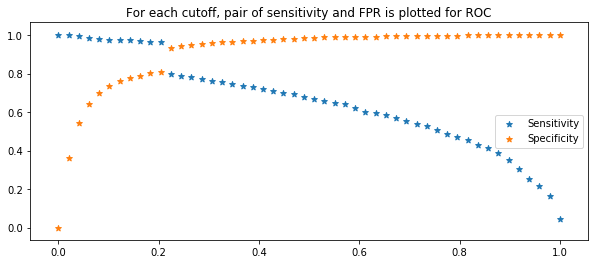

In [231]:
test_temp.sum()
plt.subplots(figsize=(10,4))
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['specificity'], marker='*', label='Specificity')
#plt.scatter(test_roc_like_df['cutoff'], 1-test_roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [232]:
## Finding ideal cut-off for checking if this remains same in OOS validation
test_roc_like_df['total'] = test_roc_like_df['sensitivity'] + test_roc_like_df['specificity']
test_roc_like_df[test_roc_like_df['total']==test_roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.204082,0.962576,0.806516,0.838018,1.769092


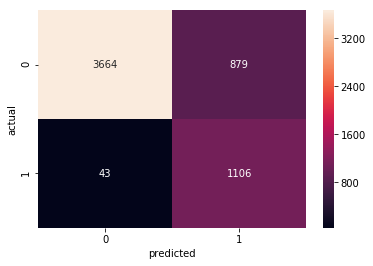

In [233]:
df_test_predict['predicted'] = df_test_predict['prob'].apply(lambda x: 1 if x > 0.204082 else 0)

import seaborn as sns
sns.heatmap(pd.crosstab(df_test_predict['actual'], df_test_predict['predicted']), annot=True, fmt='.0f')

In [234]:
accuracy=metrics.accuracy_score(df_test_predict.actual, df_test_predict.predicted)
print('Accuracy: ',round(accuracy,2))

Accuracy:  0.84


In [235]:
from sklearn.metrics import classification_report
print(classification_report(df_test_predict.actual, df_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      4543
           1       0.56      0.96      0.71      1149

    accuracy                           0.84      5692
   macro avg       0.77      0.88      0.80      5692
weighted avg       0.90      0.84      0.85      5692



# `Text Clustering`

In [236]:
train_x.shape

(13281, 320)

In [420]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [429]:
title=list2
title[0:5]

['chief financial officer',
 'community connection intern pay internship',
 'country coordinator',
 'specialist',
 'software developer']

In [440]:
# Creating the Tf-Idf model directly
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 0.01, max_df = 0.9, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(title).toarray()

In [428]:
title[]

list

In [441]:
X.shape

(16537, 48)

##### `Cluster Error`

In [446]:
cluster_range = range( 1, 21 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit(X)
    cluster_errors.append( clusters.inertia_ )

In [447]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:21]

,num_clusters,cluster_errors
0,1,13631.991020
1,2,12320.649888
2,3,11317.512593
3,4,10496.414339
4,5,9945.931517
5,6,9546.219526
6,7,9164.103347
7,8,9046.373721
8,9,8746.134975
9,10,8457.860815


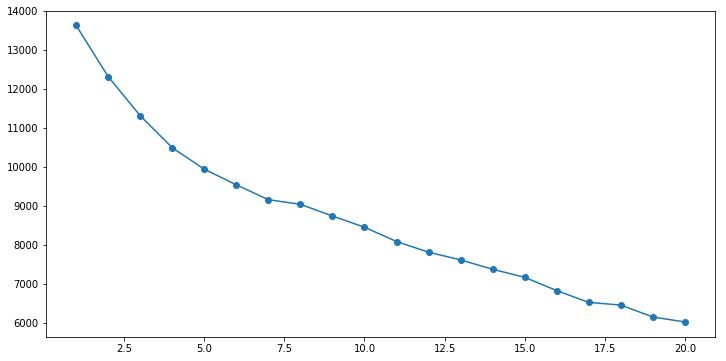

In [448]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

##### `Silhouette Coefficient`

In [449]:
from sklearn import metrics

In [450]:
# calculate SC for K=3 through K=12
k_range = range(2, 21)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    scores.append(metrics.silhouette_score(X, km.labels_))

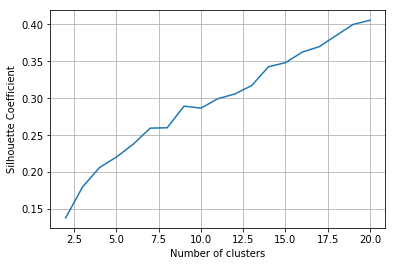

In [451]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [454]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [455]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 program
 coordinator
 manager
 assistant
 officer
 director
 support
 development
 senior
 specialist
Cluster 1:
 medical
 team
 officer
 manager
 director
 specialist
 translator
 coordinator
 sale
 project
Cluster 2:
 specialist
 developer
 senior
 software
 engineer
 sale
 assistant
 director
 designer
 consultant
Cluster 3:
 officer
 credit
 chief
 financial
 project
 finance
 senior
 executive
 administrative
 business
Cluster 4:
 manager
 sale
 project
 marketing
 office
 finance
 financial
 service
 customer
 assistant
